In [14]:
from tools.DropColumns import drop_columns
from tools.DropNa import drop_na
from tools.ParseLocation import ParseLocation
from tools.EnforceSchema import EnforceSchema
from tools.EnforceValueRanges import EnforceValueRanges
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer,PolynomialFeatures, OneHotEncoder, FunctionTransformer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression, RFE
from sklearn.svm import SVR
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


---

In [21]:
class ID3Classifier(BaseEstimator, ClassifierMixin):
    def __init__(self, min_depth=2, max_depth=None):
        self.min_depth = min_depth
        self.max_depth = max_depth
        self.tree = None
        self.majority_class = None
        self.label_map = {}

    def encode_labels(self, y):
        unique = np.unique(y)
        self.label_map = {c: i for i, c in enumerate(unique)}
        inv_map = {i: c for c, i in self.label_map.items()}
        y_encoded = np.array([self.label_map[val] for val in y])
        return y_encoded, inv_map

    def entropy(self, y):
        counts = np.bincount(y)
        probs = counts / len(y)
        return -np.sum([p * np.log2(p) for p in probs if p > 0])

    def information_gain(self, y, left, right):
        if len(left) == 0 or len(right) == 0:
            return 0
            
        total_entropy = self.entropy(y)

        n = len(y)
        
        weighted = (len(left)/n)*self.entropy(left) + (len(right)/n)*self.entropy(right)
        return total_entropy - weighted

    def best_split(self, X, y):
        """Find best numeric split: (feature, threshold, gain)."""
        best_gain = -1
        best_feature = None
        best_threshold = None

        for col in range(X.shape[1]):
            values = X[:, col]

            # sorted unique thresholds
            uniq = np.unique(values)
            
            if len(uniq) < 2:
                continue

            thresholds = np.percentile(values, np.linspace(0, 100, min(10, len(np.unique(values)))))

            for t in thresholds:
                left_mask = values <= t
                right_mask = values > t

                gain = self.information_gain(
                    y,
                    y[left_mask],
                    y[right_mask]
                )
                if gain > best_gain:
                    best_gain = gain
                    best_feature = col
                    best_threshold = t

        return best_feature, best_threshold, best_gain

    def build_tree(self, X, y, depth):
        # If all same class
        if len(np.unique(y)) == 1:
            return int(y[0])

        # Max depth reached → majority
        if self.max_depth is not None and depth >= self.max_depth:
            return Counter(y).most_common(1)[0][0]

        feature, threshold, gain = self.best_split(X, y)

        if feature is None or gain <= 0:
            return Counter(y).most_common(1)[0][0]

        left_mask = X[:, feature] <= threshold
        right_mask = X[:, feature] > threshold

        return {
            'feature': feature,
            'threshold': threshold,
            'left': self.build_tree(X[left_mask], y[left_mask], depth+1),
            'right': self.build_tree(X[right_mask], y[right_mask], depth+1)
        }

    def predict_single(self, x):
        node = self.tree

        while isinstance(node, dict):
            if x[node['feature']] <= node['threshold']:
                node = node['left']
            else:
                node = node['right']
        return node

    def fit(self, X, y):
        X = np.array(X)  # convert to NumPy
        y_encoded, self.inv_label_map = self.encode_labels(y)
        self.tree = self.build_tree(X, y_encoded, depth=1)
        return self

    def predict(self, X):
        X = np.array(X)
        encoded = np.array([self.predict_single(row) for row in X])
        return np.array([self.inv_label_map[i] for i in encoded])


In [28]:
observation_schema = {
    'SpO₂':'float',
    'HR':'float',
    'PI':'float',
    'RR':'float',
    'EtCO₂':'float',
    'FiO₂':'float',
    'PRV':'float',
    'BP':'float',
    'Skin Temperature':'float',
    'Motion/Activity index':'float',
    'PVI':'float',
    'Hb level':'float',
    'SV':'float',
    'CO':'float',
    'Blood Flow Index':'float',
    'PPG waveform features':'float',
    'Signal Quality Index':'float',
    'Respiratory effort':'float',
    'O₂ extraction ratio':'float',
    'SNR':'float',
    'oximetry':'int',
    'latitude':'float',
    'longitude':'float'
}

valid_ranges = {
    'SpO₂': (95, 100),
    'HR': (60, 100),
    'PI': (0.2, 20),
    'RR': (12, 20),
    'EtCO₂': (35, 45),
    'FiO₂': (21, 100),
    'PRV': (20, 200),
    'BP': (60, 120),
    'Skin Temperature': (33, 38),
    'Motion/Activity index': None,
    'PVI': (10, 20),
    'Hb level': (12, 18),
    'SV': (60, 100),
    'CO': (4, 8),
    'Blood Flow Index': None,
    'PPG waveform features': None,
    'Signal Quality Index': (0, 100),
    'Respiratory effort': None,
    'O₂ extraction ratio': (0.2, 3),
    'SNR': (20, 40)
}

def get_numeric_columns(df):
    return df.select_dtypes(include=['int', 'float']).columns.tolist()

numeric_pipeline = Pipeline([
    ("power", PowerTransformer(method="yeo-johnson")),
    #("poly", PolynomialFeatures(degree=2, include_bias=False)),
    #("scaler", StandardScaler()),
    ("scaler", MinMaxScaler(feature_range=(-1, 1)))
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

observation_pipeline = Pipeline([
    ("schema", EnforceSchema(schema=observation_schema)),
    ("ranges", EnforceValueRanges(ranges=valid_ranges)),
    ("drop_geo", FunctionTransformer(drop_columns, kw_args={'columns': ['latitude', 'longitude']}, validate=False)),
    ("drop_na", FunctionTransformer(drop_na, kw_args={'how': 'any'}, validate=False)),

    ("encode", ColumnTransformer([
        ('cat', cat_pipeline, []),
        ('num', numeric_pipeline, get_numeric_columns)
    ], remainder='drop').set_output(transform="pandas")),

    ("variance_threshold", VarianceThreshold(threshold=0.01).set_output(transform="pandas")),
    #("select_kbest", SelectKBest(score_func=f_regression, k=15).set_output(transform="pandas")) 
    ("RFE", RFE(SVR(kernel="linear"), n_features_to_select=5, step=1).set_output(transform="pandas")) 
])

observation = pd.read_csv("dataset/observation.csv", sep='\t')

before = len(observation)
observation = observation.drop_duplicates()
after = len(observation)
print("Removed duplicates:", before - after)

X = observation.drop(columns=["oximetry"])
y = observation["oximetry"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("train shape:", X_train.shape)
print("train shape:", y_train.shape)
print("test shape:", X_test.shape)
print("test shape:", y_test.shape)


Removed duplicates: 1
train shape: (9684, 22)
train shape: (9684,)
test shape: (2422, 22)
test shape: (2422,)


In [29]:
id3 = ID3Classifier(min_depth=2, max_depth=10)

final_pipeline = Pipeline([
    ("observation_transform", observation_pipeline),
    ("id3", id3)
])

final_pipeline.fit(X_train, y_train)
y_pred = final_pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)

print("===== ID3 CLASSIFIER EVALUATION =====")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")

===== ID3 CLASSIFIER EVALUATION =====
Accuracy:  0.8873
Precision: 0.8874
Recall:    0.8873


C:\Users\maria\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


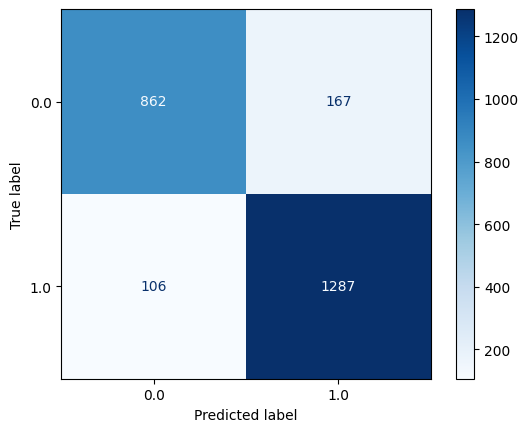

In [30]:
id3_step = final_pipeline.named_steps['id3']

labels = list(id3_step.inv_label_map.values())  

cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')


In [31]:
y_pred = final_pipeline.predict(X_train)

train_accuracy = accuracy_score(y_train, y_pred)
train_precision = precision_score(y_train, y_pred, average='weighted', zero_division=0)
train_recall = recall_score(y_train, y_pred, average='weighted', zero_division=0)

print("===== TRAIN PERFORMANCE =====")
print(f"Accuracy:  {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall:    {train_recall:.4f}")

===== TRAIN PERFORMANCE =====
Accuracy:  0.9255
Precision: 0.9254
Recall:    0.9255


C:\Users\maria\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


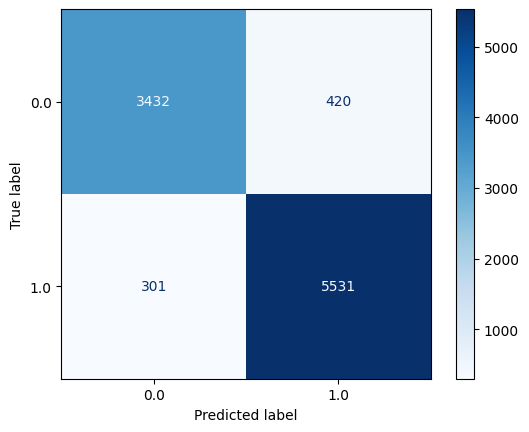

In [32]:
id3_step = final_pipeline.named_steps['id3']

labels = list(id3_step.inv_label_map.values())  

cm = confusion_matrix(y_train, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')